In [95]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [96]:
df_org = pd.read_csv('docs/t20_bbb.csv')

C:\Users\anees\AppData\Local\Temp\ipykernel_31640\1997786846.py:1: DtypeWarning: Columns (51,52,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv('docs/t20_bbb.csv')


In [97]:
df_org=df_org[(df_org['ball']<=11)]
df_org=df_org[(df_org['over']<=20)]
df_org=df_org[(df_org['batruns']>=0) & (df_org['bowlruns']>=0)]
df_org.shape

(1675723, 57)

In [98]:
def bowl_style_clean(df,unique_styles):

    df['bowl_style'] = df['bowl_style'].replace(['RFM', 'RMF'], 'RFM')
    df['bowl_style'] = df['bowl_style'].replace(['LFM', 'LMF'], 'LFM')
    df['bowl_style'] = df['bowl_style'].replace(['LBG', 'LB'], 'RWS')
    df['bowl_style'] = df['bowl_style'].replace(['LS', 'SLA'], 'SLA')
    df['bowl_style'] = df['bowl_style'].replace(['RAB'], 'RSM')
    df['bowl_style'] = df['bowl_style'].replace(['LAB'], 'LSM')
    unique_styles = ['LFM/SLA', 'OB/LB','LM/SLA/LWS','OB/SLA','RMF/OB', 'RFM/OB', 'OB/LBG', 'RFM/LBG', 'RM/LB',
           'RM/LBG', 'LMF/RM', 'RM/RSM', 'SLA/LWS', 'RMF/LB', 'RFM/LB',
           'RM/OB/LB']
    replacements = {
        'RFM': 'RFM',
        'RMF': 'RFM',
        'LFM': 'LFM',
        'LMF': 'LFM',
        'LBG': 'RWS',
        'LB': 'RWS',
        'LS': 'SLA',
        'SLA': 'SLA',
        'RAB': 'RS',
        'LAB': 'LS'
    }

    # Iterate over unique styles and apply replacements
    for style in unique_styles:
        replaced_style = '/'.join([replacements.get(part, part) for part in style.split('/')])
        df['bowl_style'] = df['bowl_style'].replace([style], replaced_style)
    #df['bowl_style'].unique()
    return df
unique_styles = ['RFM', 'RMF', 'LBG', 'LB', 'LS', 'RAB', 'LAB', 'OB', 'SLA', 'RAB','RSM','LSM']
df=bowl_style_clean(df_org,unique_styles)
df['bowl_style'].unique()

array(['RF', 'RFM', 'RWS', 'LWS', 'SLA', 'OB', 'LFM', 'LF', 'RM', 'RM/OB',
       'LM', 'LFM/SLA', 'OB/RWS', 'LM/SLA/LWS', 'OB/SLA', 'RSM', '-',
       'LSM', 'RFM/OB', 'RFM/RWS', 'RM/RWS', 'LFM/RM', 'RM/RSM',
       'SLA/LWS', 'RM/OB/RWS', 'RS'], dtype=object)

In [99]:
df_worldcup = pd.read_csv('docs/2024 wc squad.csv', encoding='latin1')
df_worldcup.head()

,Afghanistan,Australia,Bangladesh,Canada,England,India,Ireland,Namibia,Nepal,Netherlands,New Zealand,Oman,Papua New Guinea,Scotland,South Africa,Sri Lanka,Uganda,United States,West Indies,Pakistan
0,Rashid Khan,Mitchell Marsh,Najmul Hossain Shanto,Saad Bin Zafar,Jos Buttler,Rohit Sharma,Paul Stirling,Gerhard Erasmus,Rohit Paudel,Scott Edwards,Kane Williamson,Aqib Ilyas,Assad Vala,Richie Berrington,Aiden Markram,Wanindu Hasaranga,Brian Masaba,Monank Patel,Rovman Powell,NaN
1,Ibrahim Zadran,Ashton Agar,Taskin Ahmed,Aaron Johnson,Moeen Ali,Hardik Pandya,Mark Adair,Zane Green,Aasif Sheikh,Aryan Dutt,Finn Allen,Zeeshan Maqsood,Alei Nao,Matthew Cross,Ottniel Baartman,Charith Asalanka,Simon Ssesazi,Aaron Jones,Alzarri Joseph,NaN
2,Azmatullah Omarzai,Pat Cummins,Litton Das,Dillon Heyliger,Jofra Archer,Yashasvi Jaiswal,Ross Adair,Michael van Lingen,Anil Kumar Sah,Bas de Leede,Trent Boult,Kashyap Prajapati,Chad Soper,Bradley Currie,Gerald Coetzee,Kusal Mendis,Roger Mukasa,Andries Gous,Johnson Charles,NaN
3,Najibullah Zadran,Tim David,Soumya Sarkar,Dilpreet Bajwa,Jonny Bairstow,Virat Kohli,Andy Balbirnie,Dylan Leicher,Kushal Bhurtel,Saqib Zulfiqar,Michael Bracewell,Pratik Athavale,Charles Amini,Chris Greaves,Quinton de Kock,Pathum Nissanka,Cosmas Kyewuta,Corey Anderson,Roston Chase,NaN
4,Mohammad Ishaq,Nathan Ellis,Tanzid Hasan,Harsh Thaker,Harry Brook,Suryakumar Yadav,Curtis Campher,Ruben Trumpelmann,Kushal Malla,Kyle Klein,Mark Chapman,Ayaan Khan,Hila Vare,Oli Carter,Bjorn Fortuin,Kamindu Mendis,Dinesh Nakrani,Ali Khan,Shimron Hetmyer,NaN


In [100]:
team_dict = df_worldcup.to_dict(orient='list')

print(team_dict['Afghanistan'])

['Rashid Khan', 'Ibrahim Zadran', 'Azmatullah Omarzai', 'Najibullah Zadran', 'Mohammad Ishaq', 'Mohammad Nabi', 'Gulbadin Naib', 'Karim Janat', 'Nangeyalia Kharote', 'Mujeeb Ur Rahman', 'Noor Ahmad', 'Naveen-ul-Haq', 'Fazalhaq Farooqi', 'Fareed Ahmad', nan, nan]


In [101]:
team_dict = {key.strip(): [value.strip() for value in values if pd.notna(value)] for key, values in team_dict.items()}

team_dict['Afghanistan']

['Rashid Khan',
 'Ibrahim Zadran',
 'Azmatullah Omarzai',
 'Najibullah Zadran',
 'Mohammad Ishaq',
 'Mohammad Nabi',
 'Gulbadin Naib',
 'Karim Janat',
 'Nangeyalia Kharote',
 'Mujeeb Ur Rahman',
 'Noor Ahmad',
 'Naveen-ul-Haq',
 'Fazalhaq Farooqi',
 'Fareed Ahmad']

In [102]:
players_list = np.concatenate((df['bowl'].unique(), df['bat'].unique()))
for team,players in team_dict.items():
    for player in players:
        if ((player not in players_list)|(player not in players_list)):
            print(team,player)

Canada Kanwarpal Tathgur
Nepal Anil Kumar Sah
United States Shayan Jahangir


In [103]:
players=set()
for key,vals in team_dict.items():
    players.update(vals)

In [104]:
matches_relevant=df[df['bat'].isin(players) | df['bowl'].isin(players)]['p_match'].unique()
df=df[df['p_match'].isin(matches_relevant)]

In [105]:
df_player_id_combs=df[['bat','p_bat','bowl','p_bowl']].drop_duplicates()

In [106]:
# Create a mapping of player names to player IDs
player_id_map = {}
for index, row in df_player_id_combs.iterrows():
    if row['bat'] in player_id_map:
        continue
    player_id_map[row['bat']] = row['p_bat']
    player_id_map[row['bowl']] = row['p_bowl']
# Initialize lists to store data
player_names = []
countries = []
player_ids = []

# Iterate over the dictionary
for country, players in team_dict.items():
    for player in players:
        player_names.append(player)
        countries.append(country)
        player_ids.append(player_id_map.get(player, None))

# Create DataFrame from lists
team_df = pd.DataFrame({'Player': player_names, 'Country': countries, 'p_id': player_ids})
team_df['p_id'] = team_df['p_id'].astype('Int64')
team_df.head()

,Player,Country,p_id
0,Rashid Khan,Afghanistan,793463
1,Ibrahim Zadran,Afghanistan,921509
2,Azmatullah Omarzai,Afghanistan,819429
3,Najibullah Zadran,Afghanistan,524049
4,Mohammad Ishaq,Afghanistan,1076579


In [107]:
worldcup_pitches=['Kensington Oval, Bridgetown, Barbados',
                  'Sir Vivian Richards Stadium, North Sound, Antigua',
                  'Providence Stadium, Guyana',
                  'Daren Sammy National Cricket Stadium, Gros Islet, St Lucia',
                  'Brian Lara Stadium, Tarouba, Trinidad',
                  'Arnos Vale Ground, Kingstown, St Vincent',
                  'Central Broward Regional Park Stadium Turf Ground, Lauderhill',
                  'Nassau County International Cricket Stadium',
                  'Grand Prairie Stadium'
                 ]

In [108]:
df.columns

Index(['p_match', 'inns', 'bat', 'p_bat', 'team_bat', 'bowl', 'p_bowl',
       'team_bowl', 'ball', 'ball_id', 'outcome', 'score', 'out', 'dismissal',
       'p_out', 'over', 'noball', 'wide', 'byes', 'legbyes', 'cur_bat_runs',
       'cur_bat_bf', 'cur_bowl_ovr', 'cur_bowl_wkts', 'cur_bowl_runs',
       'inns_runs', 'inns_wkts', 'inns_balls', 'inns_runs_rem',
       'inns_balls_rem', 'inns_rr', 'inns_rrr', 'target', 'max_balls', 'date',
       'year', 'ground', 'country', 'winner', 'toss', 'competition',
       'bat_hand', 'bowl_style', 'bowl_kind', 'batruns', 'ballfaced',
       'bowlruns', 'bat_out', 'wagonX', 'wagonY', 'wagonZone', 'line',
       'length', 'shot', 'control', 'predscore', 'wprob'],
      dtype='object')

In [109]:
def custom_agg(x):
    result = (x['batruns'].sum() * 120) / x['ballfaced'].sum()
    return round(result, 2)
def get_ground_avgscores(df):
    df1=df[df['ground'].isin(worldcup_pitches)].groupby(['p_match', 'inns','ground']).agg({'batruns':'sum','ballfaced':'sum'}).reset_index()
    # Define custom aggregation function
    # Group by 'inns' and 'ground', and aggregate using custom aggregation function
    result_df = df1.groupby(['ground']).apply(custom_agg).reset_index(name='average_score')

    return result_df
df_groundavg=get_ground_avgscores(df)
df_groundavg

,ground,average_score
0,"Brian Lara Stadium, Tarouba, Trinidad",140.95
1,Central Broward Regional Park Stadium Turf Gro...,153.98
2,"Daren Sammy National Cricket Stadium, Gros Isl...",152.78
3,"Kensington Oval, Bridgetown, Barbados",147.34
4,"Providence Stadium, Guyana",145.48
5,"Sir Vivian Richards Stadium, North Sound, Antigua",134.26


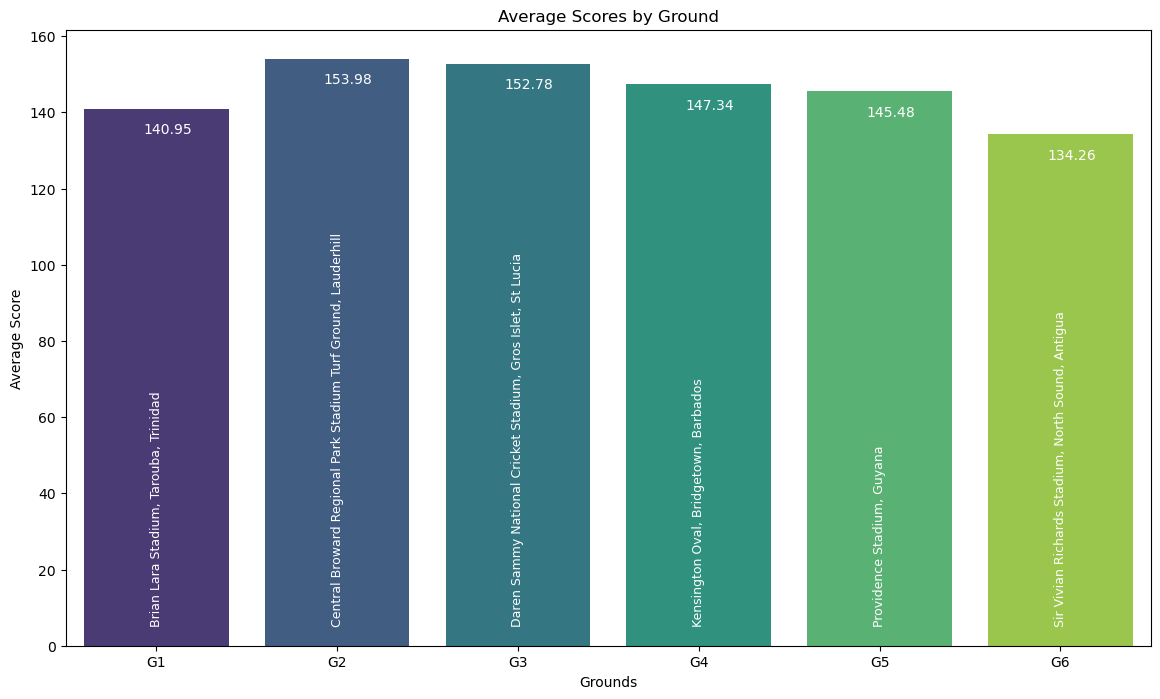

In [110]:
# Create a dictionary for ground indexes
ground_index = {ground: f'G{i}' for i, ground in enumerate(df_groundavg['ground'].unique(), 1)}

# Add the index to the dataframe
df_groundavg['ground_index'] = df_groundavg['ground'].map(ground_index)

plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(x='ground_index', y='average_score', data=df_groundavg, palette='viridis')

# Annotate bars with ground names outside and scores inside
for p, label in zip(ax.patches, df_groundavg['ground']):
    height = p.get_height()
    ax.annotate(format(height, '.2f'), 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (8, -15), 
                textcoords = 'offset points', color='white')
    
    ax.annotate(label, 
                (p.get_x() + p.get_width() / 2., 5), 
                ha = 'center', va = 'bottom', 
                fontsize=9, rotation=90, color='white')

# Title and labels
plt.title('Average Scores by Ground')
plt.xlabel('Grounds')
plt.ylabel('Average Score')

# # Create the legend for ground names
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, ['Innings 1', 'Innings 2'], title='Innings')

plt.show()

In [111]:
df_groundavg.to_csv('docs/WC Analysis results/scoreavg_ground.csv')

In [112]:
def get_ground_batstats_vs_bowlkind(df):
    df2=df[(df['ground'].isin(worldcup_pitches))&(df['bowl_kind'].isin(['pace bowler','spin bowler']))]
    df2_runs=df2.groupby(['ground','bowl_kind']).agg({'batruns':'sum','ballfaced':'sum','p_match':'nunique'}).reset_index()
    df2_outs=df[(df['out']==True)&(df['ground'].isin(worldcup_pitches))&(df['bowl_kind'].isin(['pace bowler','spin bowler']))].groupby(['ground','bowl_kind']).size().reset_index(name='outs')
    df2_batting=pd.merge(df2_runs,df2_outs,on=['ground','bowl_kind'])
    df2_batting['average']=round(df2_batting['batruns']/df2_batting['outs'],2)
    df2_batting['strike rate']=round(df2_batting['batruns']*100/df2_batting['ballfaced'],2)
    df2_batting.drop(columns=['batruns','ballfaced','outs'],inplace=True)
    df2_batting.rename(columns={'p_match':'matches'},inplace=True)
    return df2_batting
df2_batting=get_ground_batstats_vs_bowlkind(df)
df2_batting.head()

,ground,bowl_kind,matches,average,strike rate
0,"Brian Lara Stadium, Tarouba, Trinidad",pace bowler,43,20.98,128.26
1,"Brian Lara Stadium, Tarouba, Trinidad",spin bowler,43,20.71,106.38
2,Central Broward Regional Park Stadium Turf Gro...,pace bowler,21,25.00,138.15
3,Central Broward Regional Park Stadium Turf Gro...,spin bowler,21,23.08,113.52
4,"Daren Sammy National Cricket Stadium, Gros Isl...",pace bowler,15,20.67,131.66


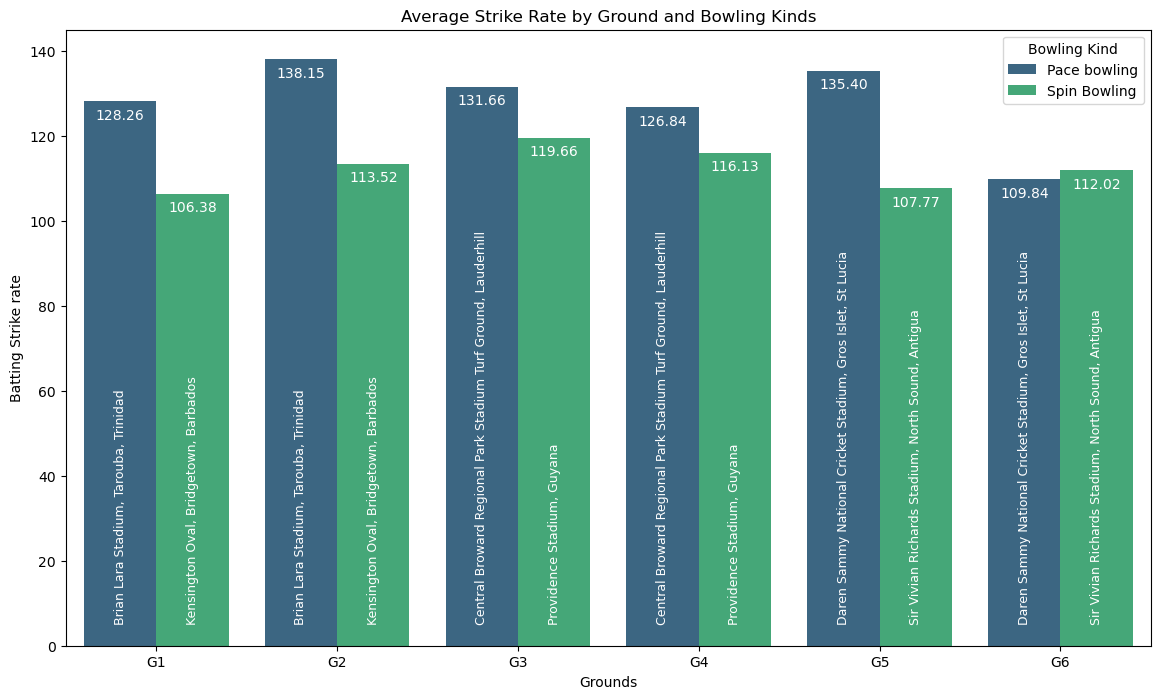

In [113]:
ground_index = {ground: f'G{i}' for i, ground in enumerate(df2_batting['ground'].unique(), 1)}

# Add the index to the dataframe
df2_batting['ground_index'] = df2_batting['ground'].map(ground_index)

plt.figure(figsize=(14, 8))

# Create the bar plot
ax = sns.barplot(x='ground_index', y='strike rate', hue='bowl_kind', data=df2_batting, palette='viridis')

# Annotate bars with ground names outside and scores inside
for p, label in zip(ax.patches, df2_batting['ground']):
    height = p.get_height()
    ax.annotate(format(height, '.2f'), 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, -10), 
                textcoords = 'offset points', color='white')
    
    ax.annotate(label, 
                (p.get_x() + p.get_width() / 2., 5), 
                ha = 'center', va = 'bottom', 
                fontsize=9, rotation=90, color='white')

# Title and labels
plt.title('Average Strike Rate by Ground and Bowling Kinds')
plt.xlabel('Grounds')
plt.ylabel('Batting Strike rate')

# Create the legend for ground names
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Pace bowling', 'Spin Bowling'], title='Bowling Kind')

plt.show()

In [114]:
df2_batting.to_csv("docs/WC Analysis results/batting_bowlkind_by_ground.csv")

In [115]:
def get_battingstats(df):
    df3=pd.merge(df[df['bat'].isin(team_df[team_df['p_id'].isna()==False]['Player'])],team_df[team_df['p_id'].isna()==False],left_on='p_bat',right_on='p_id',how='inner')
    df3_bat=df3.groupby(['Country']).agg({'batruns':'sum','ballfaced':'sum','p_match':'nunique'}).reset_index()
    df3_outs=df3[df3['out']==True].groupby(['Country']).size().reset_index(name='outs')
    df3_bat_stats=pd.merge(df3_bat,df3_outs,on='Country')
    df3_bat_stats['bat_avg']=round(df3_bat_stats['batruns']/df3_bat_stats['outs'],2)
    df3_bat_stats['bat_sr']=round(df3_bat_stats['batruns']*100/df3_bat_stats['ballfaced'],2)
    df3_dots=df3[(df3['bowlruns']==0) & (df3['ballfaced']==1)].groupby(['Country']).agg({'ballfaced':'sum'}).reset_index()
    df3_dots.rename(columns={'ballfaced':'dotballs'},inplace=True)
    df3_bat_stats=pd.merge(df3_bat_stats,df3_dots,on="Country")
    df3_bat_stats['dot%']=(df3_bat_stats['dotballs']*100/df3_bat_stats['ballfaced']).round(2)
    def custom_agg(x):
        boundary_runs = x['batruns'].sum()
        return boundary_runs
    # Apply the custom aggregation function and reset index
    df3_bd = df3[((df3['batruns'] == 4) | (df3['batruns'] == 6)) & (df3['ballfaced'] == 1)] \
                .groupby(['Country']).apply(custom_agg).reset_index(name='boundary_runs')
    df3_bat_stats=pd.merge(df3_bat_stats,df3_bd,on="Country")
    df3_bat_stats['boundary%']=(df3_bat_stats['boundary_runs']*100/df3_bat_stats['batruns']).round(2)
    df3_bat_stats.drop(columns=['batruns', 'ballfaced', 'dotballs','boundary_runs','outs'],inplace=True)
    df3_bat_stats.rename(columns={'p_match':'matches_batted'},inplace=True)
    return df3_bat_stats
df3_bat_stats=get_battingstats(df)
df3_bat_stats.head()

,Country,matches_batted,bat_avg,bat_sr,dot%,boundary%
0,Afghanistan,688,20.43,133.67,37.96,60.02
1,Australia,1043,29.11,142.94,33.89,60.12
2,Bangladesh,625,22.18,121.91,38.51,56.56
3,Canada,46,29.84,136.81,37.42,60.04
4,England,1247,27.51,144.90,34.67,63.27


In [116]:
def get_bowling_stats(df):
    df4=pd.merge(df[df['bowl'].isin(team_df[team_df['p_id'].isna()==False]['Player'])],team_df[team_df['p_id'].isna()==False],left_on='p_bowl',right_on='p_id',how='inner')
    df4_bowl=df4.groupby(['Country']).agg({'bowlruns':'sum','ballfaced':'sum','p_match':'nunique'}).reset_index()
    df4_bowl['economy']=(df4_bowl['bowlruns']*6/df4_bowl['ballfaced']).round(2)
    df4_outs=df4[df4['out']==True].groupby(['Country']).size().reset_index(name='outs')
    df4_bowl_stats=pd.merge(df4_bowl,df4_outs,on='Country')
    df4_bowl_stats['bowl_avg']=round(df4_bowl_stats['bowlruns']/df4_bowl_stats['outs'],2)
    df4_bowl_stats['bowl_sr']=round(df4_bowl_stats['ballfaced']/df4_bowl_stats['outs'],2)
    df4_bowl_stats.drop(columns=['bowlruns','ballfaced','outs'],inplace=True)
    df4_bowl_stats.rename(columns={'p_match':'matches_bowled'},inplace=True)
    return df4_bowl_stats
df4_bowl_stats=get_bowling_stats(df)
df4_bowl_stats.head()

,Country,matches_bowled,economy,bowl_avg,bowl_sr
0,Afghanistan,984,7.17,21.36,17.86
1,Australia,817,7.96,24.28,18.30
2,Bangladesh,664,7.44,21.08,16.99
3,Canada,45,6.76,18.70,16.59
4,England,956,8.11,23.12,17.10


In [117]:
overall_team_stats=pd.merge(df3_bat_stats,df4_bowl_stats,on='Country').sort_values('matches_batted',ascending=False).reset_index().drop(columns='index').head(10)
overall_team_stats.drop(columns=['matches_batted','matches_bowled'],inplace=True)
overall_team_stats.set_index('Country', inplace=True)
overall_team_stats

,bat_avg,bat_sr,dot%,boundary%,economy,bowl_avg,bowl_sr
Country,,,,,,,
England,27.51,144.90,34.67,63.27,8.11,23.12,17.10
Australia,29.11,142.94,33.89,60.12,7.96,24.28,18.30
West Indies,25.75,140.99,39.39,66.36,8.29,23.41,16.94
New Zealand,28.16,137.33,34.00,58.14,8.09,23.17,17.18
South Africa,28.61,136.65,34.11,58.48,7.52,21.35,17.04
India,31.11,140.32,34.14,61.00,7.85,24.09,18.42
Afghanistan,20.43,133.67,37.96,60.02,7.17,21.36,17.86
Bangladesh,22.18,121.91,38.51,56.56,7.44,21.08,16.99
Sri Lanka,25.68,128.52,36.27,57.05,7.62,23.07,18.16


In [118]:
overall_team_stats.to_csv("docs/WC Analysis results/overall_team_stats.csv")

In [123]:
cols_increase=['bat_avg','bat_sr','boundary%']
cols_decrease=['dot%','economy','bowl_avg','bowl_sr']
def normalization(cols_increase, cols_decrease, overall_team_stats):
    # Create an empty DataFrame for normalized values
    normalized_df = pd.DataFrame(index=overall_team_stats.index)
    
    # Normalize columns where an increase is favorable
    for col in cols_increase:
        mean = overall_team_stats[col].mean()
        std = overall_team_stats[col].std()
        normalized_df[col] = (overall_team_stats[col] - mean) / std

    # Normalize columns where a decrease is favorable
    for col in cols_decrease:
        mean = overall_team_stats[col].mean()
        std = overall_team_stats[col].std()
        normalized_df[col] = (mean - overall_team_stats[col]) / std
    
    # Rank the teams based on normalized values
    ranked_df = normalized_df.rank(axis=0, method='min', ascending=False).astype(int)
    
    # Calculate the overall rank as the mean of individual ranks
    ranked_df['overallrank'] = ranked_df.mean(axis=1).rank(method='min', ascending=True).astype(int)
    
    # Sort the DataFrame based on the overall rank
    ranked_df = ranked_df.sort_values(by='overallrank')
    
    return normalized_df, ranked_df
normalized_df,ranked_df=normalization(cols_increase,cols_decrease,overall_team_stats)
normalized_df.head()

,bat_avg,bat_sr,boundary%,dot%,economy,bowl_avg,bowl_sr
Country,,,,,,,
England,0.415099,1.261650,1.010896,0.651769,-0.913783,-0.394142,0.494691
Australia,0.868758,0.980678,-0.044564,1.009784,-0.482753,-1.356679,-1.251278
West Indies,-0.083927,0.701139,2.046251,-1.514675,-1.431019,-0.634776,0.727487
New Zealand,0.599398,0.176468,-0.707995,0.959294,-0.856312,-0.435631,0.378293
South Africa,0.726990,0.078987,-0.594073,0.908805,0.781601,1.074556,0.581990


In [124]:
ranked_df.head()

,bat_avg,bat_sr,boundary%,dot%,economy,bowl_avg,bowl_sr,overallrank
Country,,,,,,,,
South Africa,3,6,7,3,3,2,4,1
England,5,1,2,5,9,6,5,2
Australia,2,2,5,1,7,10,9,3
India,1,4,4,4,5,9,10,4
Ireland,9,7,3,7,6,4,1,4


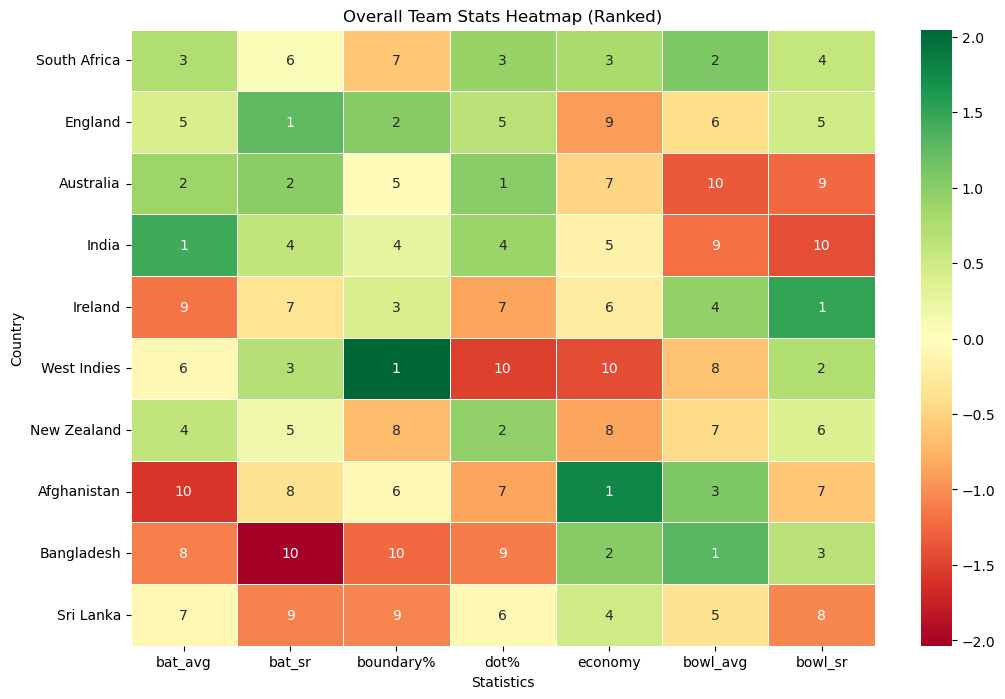

In [125]:
normalized_df=normalized_df.reindex(ranked_df.index)

plt.figure(figsize=(12, 8))
sns.heatmap(normalized_df, annot=ranked_df.drop(columns='overallrank'), fmt='d', cmap='RdYlGn', linewidths=.5, center=0)

# Title and labels
plt.title('Overall Team Stats Heatmap (Ranked)')
plt.xlabel('Statistics')
plt.ylabel('Country')

# Show the plot
plt.show()

In [126]:
df_bat_pp=get_battingstats(df[df['over']<=5])
df_bat_mid=get_battingstats(df[(df['over']>=6)&(df['over']<=14)])
df_bat_death=get_battingstats(df[(df['over']>=15)])
df_bowl_pp=get_bowling_stats(df[df['over']<=5])
df_bowl_mid=get_bowling_stats(df[(df['over']>=6)&(df['over']<=14)])
df_bowl_death=get_bowling_stats(df[(df['over']>=15)])

In [128]:
df_bowl_death

,Country,matches_bowled,economy,bowl_avg,bowl_sr
0,Afghanistan,771,8.14,16.92,12.47
1,Australia,559,9.20,18.68,12.19
2,Bangladesh,493,8.82,17.17,11.68
3,Canada,39,7.32,13.66,11.19
4,England,718,8.98,18.42,12.31
5,India,580,8.87,18.37,12.42
6,Ireland,243,8.85,16.21,10.98
7,Namibia,247,8.55,17.31,12.14
8,Nepal,85,8.66,15.78,10.94
9,Netherlands,160,8.90,19.32,13.02


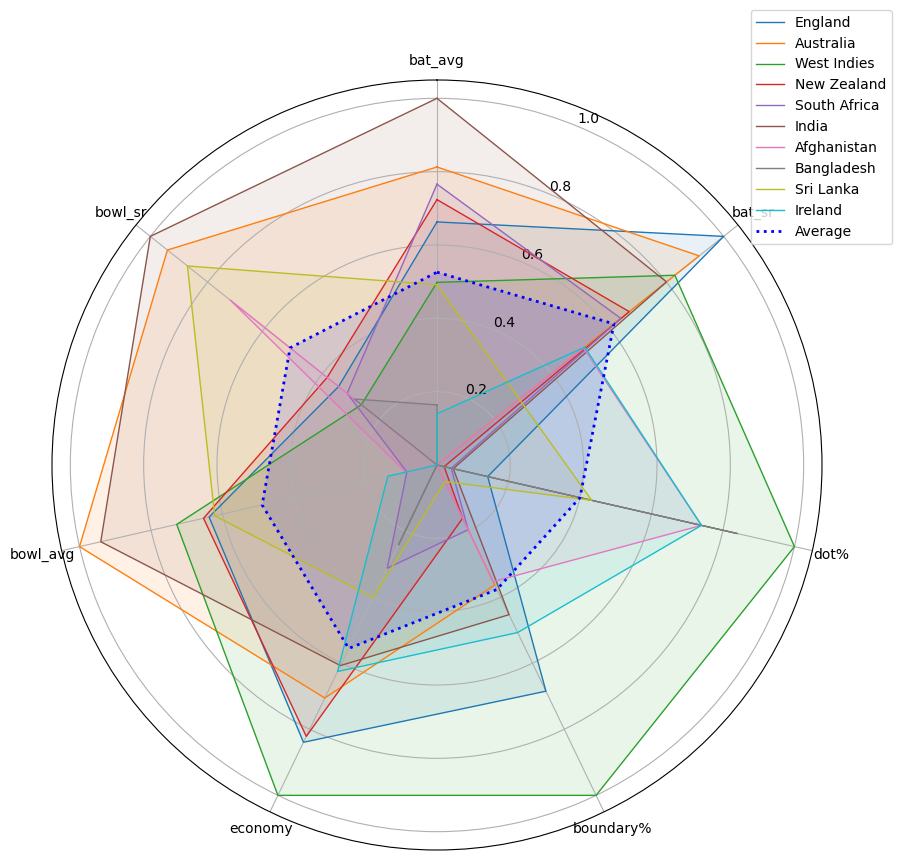

In [38]:
#df=overall_team_stats
# Normalize the data
normalized_df = (overall_team_stats - overall_team_stats.min()) / (overall_team_stats.max() - overall_team_stats.min())

# Calculate the average values for normalized data
averages = normalized_df.mean()

# Plot
attributes = overall_team_stats.columns
num_vars = len(attributes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable and add labels
plt.xticks(angles[:-1], attributes)

# Plot each individual country
for country in normalized_df.index:
    values = normalized_df.loc[country].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=country)
    ax.fill(angles, values, alpha=0.1)

# Plot the average values
average_values = averages.tolist()
average_values += average_values[:1]
ax.plot(angles, average_values, linewidth=2, linestyle='dotted', label='Average', color='blue')

# Fill area for the average values
ax.fill(angles, average_values, 'b', alpha=0.1)

# Add a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the plot
plt.show()

In [88]:
def spider_plot_stats(normalized_df,country):

    # Calculate the average values for normalized data
    averages = normalized_df.mean()

    # Plot
    attributes = normalized_df.columns
    num_vars = len(attributes)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], attributes)

    # Plot each individual country
    #for country in normalized_df.index:
    values = normalized_df.loc[country].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=country)
    ax.fill(angles, values, alpha=0.1)

    # Plot the average values
    average_values = averages.tolist()
    average_values += average_values[:1]
    ax.plot(angles, average_values, linewidth=2, linestyle='dotted', label='Average', color='blue')

    # Fill area for the average values
    ax.fill(angles, average_values, 'b', alpha=0.1)

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()


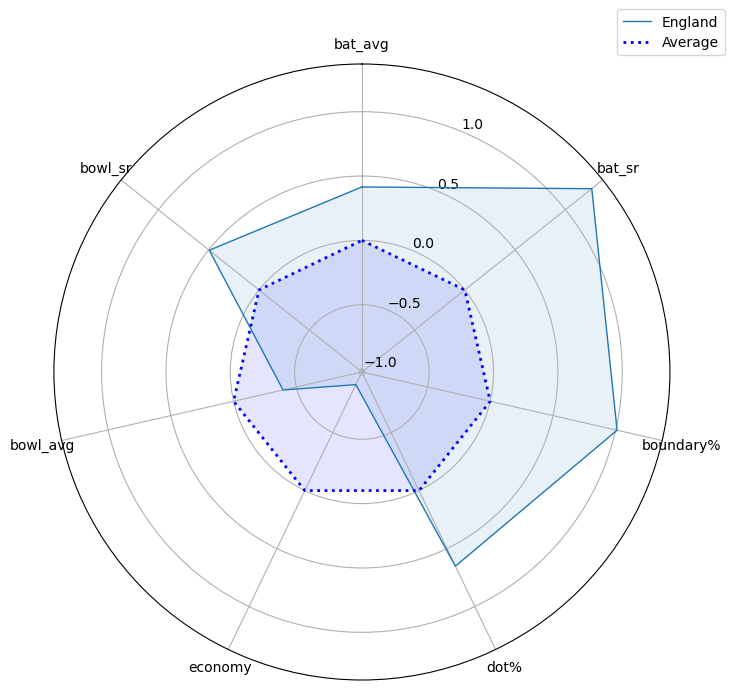

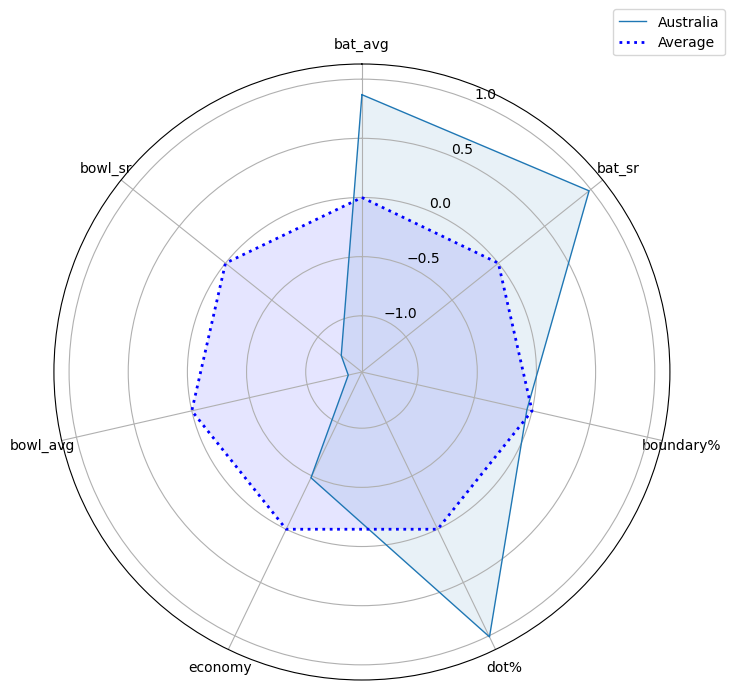

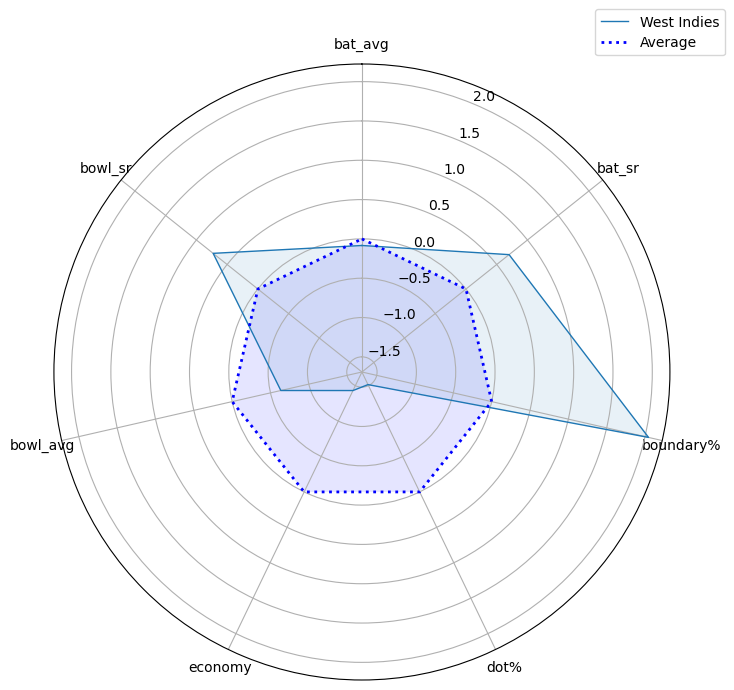

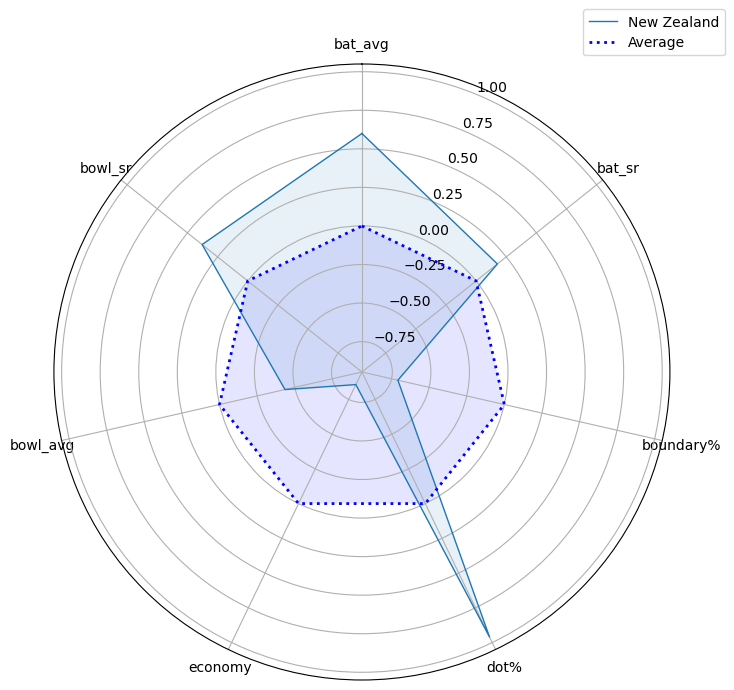

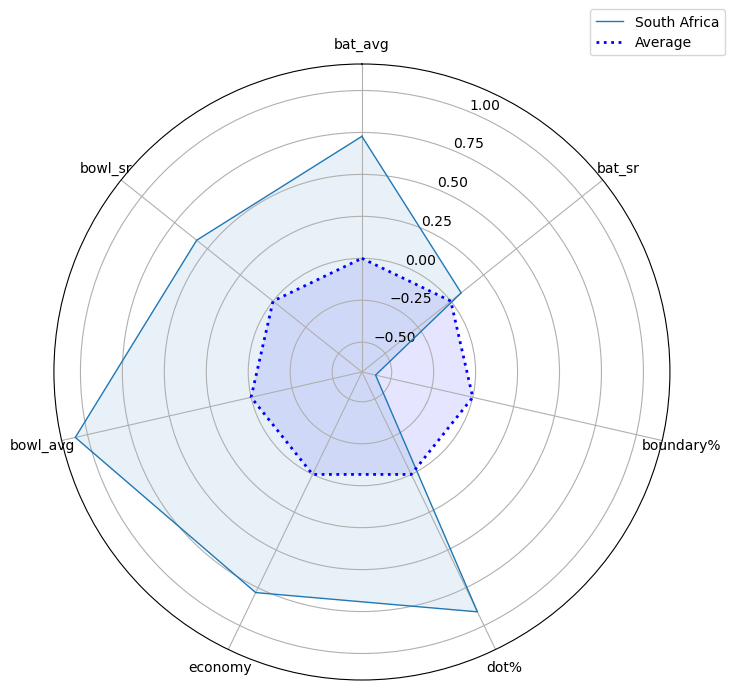

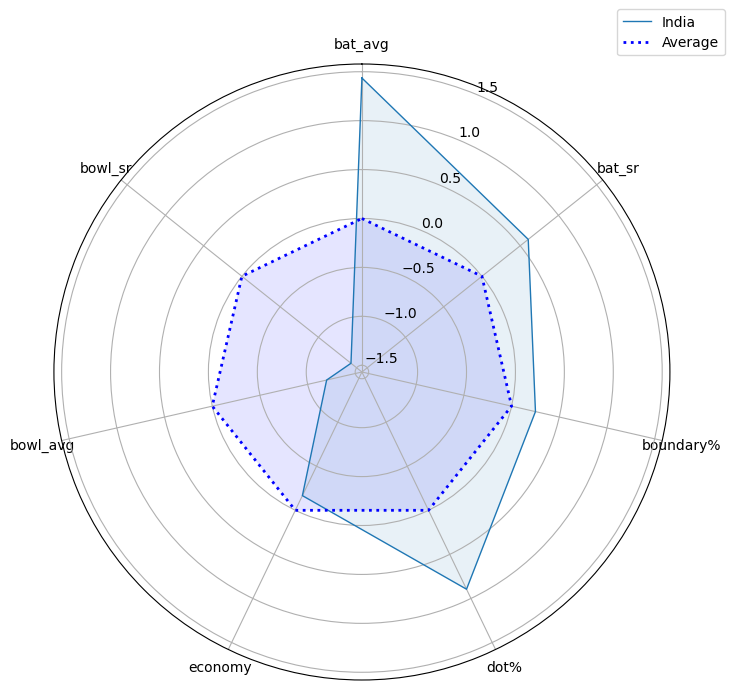

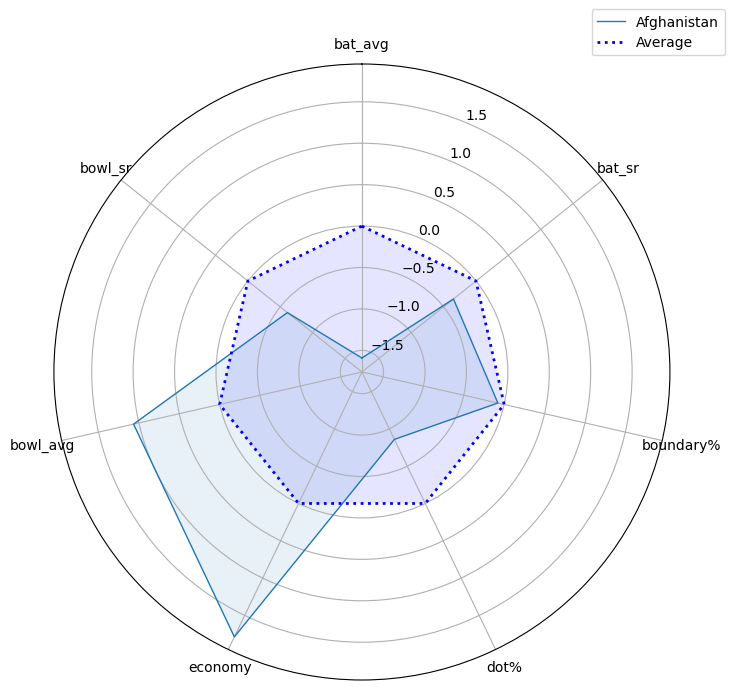

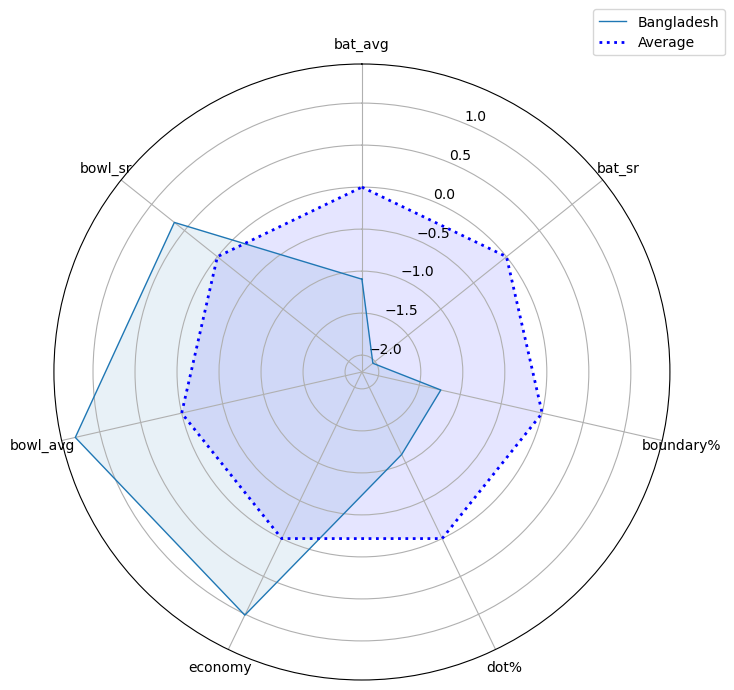

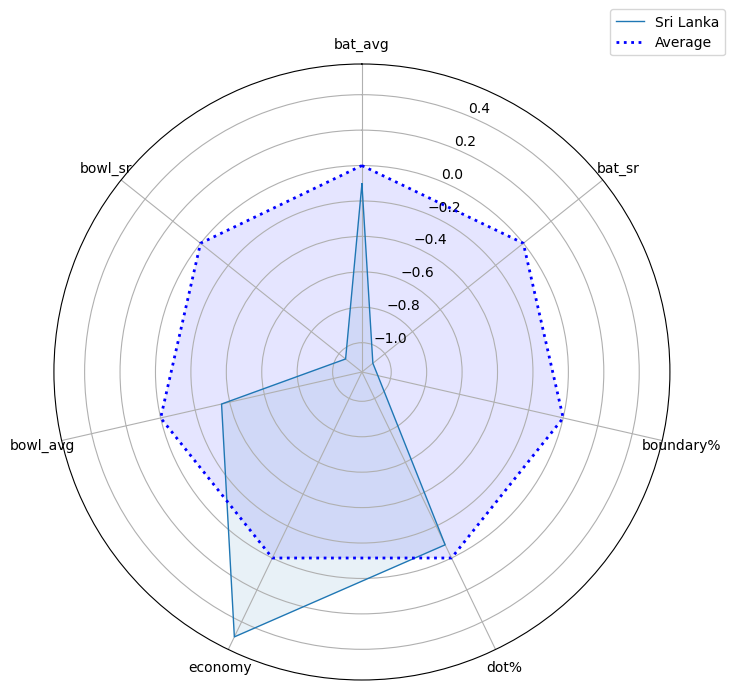

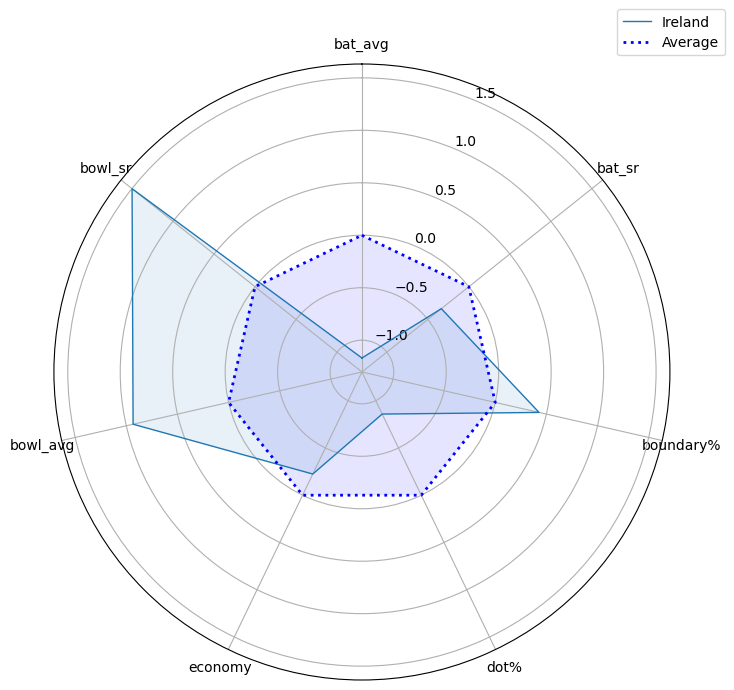

In [89]:
normalized_df,_=normalization(['bat_avg','bat_sr','boundary%'],['dot%','economy','bowl_avg','bowl_sr'],overall_team_stats)
for country in normalized_df.index:
    spider_plot_stats(normalized_df,country)

In [40]:
df_bat_pp['Phase'] = 'pp'
df_bat_mid['Phase'] = 'mid'
df_bat_death['Phase'] = 'death'
df_bowl_pp['Phase'] = 'pp'
df_bowl_mid['Phase'] = 'mid'
df_bowl_death['Phase'] = 'death'

In [41]:
df_phases_bat = pd.concat([df_bat_pp, df_bat_mid, df_bat_death], ignore_index=True)
df_phases_bat.drop(columns=['matches_batted','dot%','boundary%'],inplace=True)
df_phases_bat_norm,_=normalization(['bat_avg','bat_sr'],[],df_phases_bat[['bat_avg','bat_sr']])
for c in df_phases_bat_norm.columns:
    df_phases_bat[c]=df_phases_bat_norm[c]
df_phases_bat['bat']=round(0.5*df_phases_bat['bat_avg']+0.5*df_phases_bat['bat_sr'],2)
df_phases_bat.drop(columns=['bat_avg','bat_sr'],inplace=True)
df_phases_bat.head()

,Country,Phase,bat
0,Afghanistan,pp,-0.22
1,Australia,pp,0.97
2,Bangladesh,pp,-0.71
3,Canada,pp,0.89
4,England,pp,0.96


In [42]:
df_phases_bowl = pd.concat([df_bowl_pp, df_bowl_mid, df_bowl_death], ignore_index=True)
df_phases_bowl.drop(columns=['matches_bowled','bowl_sr'],inplace=True)
df_phases_bowl_norm,_=normalization(['economy','bowl_avg'],[],df_phases_bowl[['economy','bowl_avg']])
for c in df_phases_bowl_norm.columns:
    df_phases_bowl[c]=df_phases_bowl_norm[c]
df_phases_bowl['bowl']=round(0.5*df_phases_bowl['economy']+0.5*df_phases_bowl['bowl_avg'],2)
df_phases_bowl.drop(columns=['economy','bowl_avg'],inplace=True)
df_phases_bowl.head()

,Country,Phase,bowl
0,Afghanistan,pp,0.15
1,Australia,pp,0.70
2,Bangladesh,pp,-0.26
3,Canada,pp,-1.31
4,England,pp,0.79


In [91]:
# Initialize final DataFrame
df_phases = pd.DataFrame(columns=['Country', 'batting_pp', 'bowling_pp', 'batting_mid', 'bowling_mid', 'batting_death', 'bowling_death'])
df_phases['Country'] = df_phases_bowl['Country'].unique()

# Populate final DataFrame
for phase in ['pp', 'mid', 'death']:
    bat_phase = df_phases_bat[df_phases_bat['Phase'] == phase].set_index('Country')['bat']
    bowl_phase = df_phases_bowl[df_phases_bowl['Phase'] == phase].set_index('Country')['bowl']
    df_phases[f'batting_{phase}'] = df_phases['Country'].map(bat_phase)
    df_phases[f'bowling_{phase}'] = df_phases['Country'].map(bowl_phase)

df_phases.head()

,Country,batting_pp,bowling_pp,batting_mid,bowling_mid,batting_death,bowling_death
0,Afghanistan,-0.22,0.15,-0.61,-0.27,-0.08,-0.23
1,Australia,0.97,0.70,0.57,0.60,0.67,0.51
2,Bangladesh,-0.71,-0.26,-0.42,-0.04,-0.60,0.15
3,Canada,0.89,-1.31,0.38,0.20,0.94,-1.00
4,England,0.96,0.79,0.56,0.50,0.34,0.37


In [92]:
df_phases=df_phases[df_phases['Country'].isin(ranked_df.index)]
df_phases.to_csv("docs/WC Analysis results/phases.csv")
df_phases['overall']=round(df_phases.drop(columns=['Country']).mean(axis=1),2)
desired_order=['Country', 'overall', 'batting_pp','batting_mid','batting_death','bowling_pp','bowling_mid','bowling_death']
df_phases=df_phases[desired_order]
df_phases.set_index('Country', inplace=True)
df_phases=df_phases.reindex(ranked_df.index)
df_phases.head()

,overall,batting_pp,batting_mid,batting_death,bowling_pp,bowling_mid,bowling_death
Country,,,,,,,
South Africa,0.24,0.12,0.57,0.59,0.12,-0.15,0.16
England,0.59,0.96,0.56,0.34,0.79,0.50,0.37
Australia,0.67,0.97,0.57,0.67,0.70,0.60,0.51
India,0.67,0.68,0.80,0.85,0.83,0.54,0.31
Ireland,-0.04,-0.09,-0.23,-0.48,-0.11,0.63,0.06


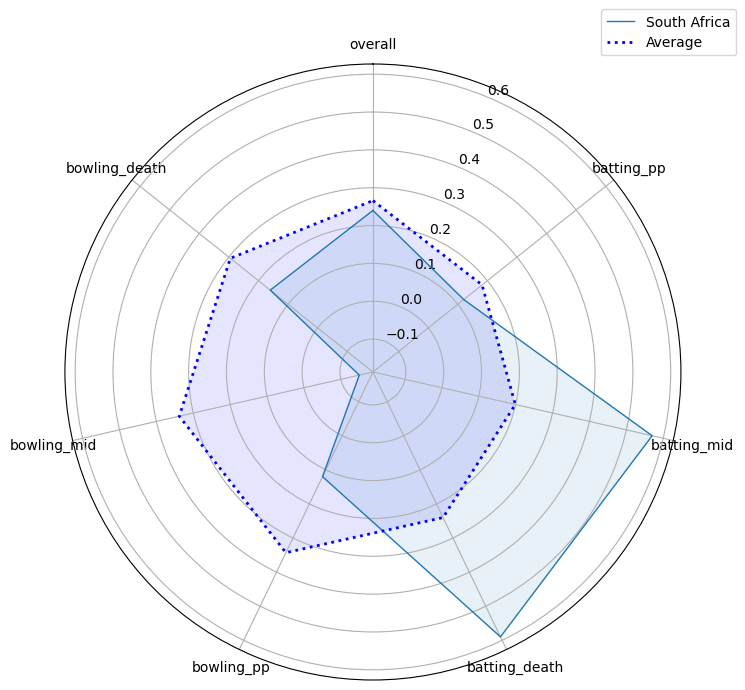

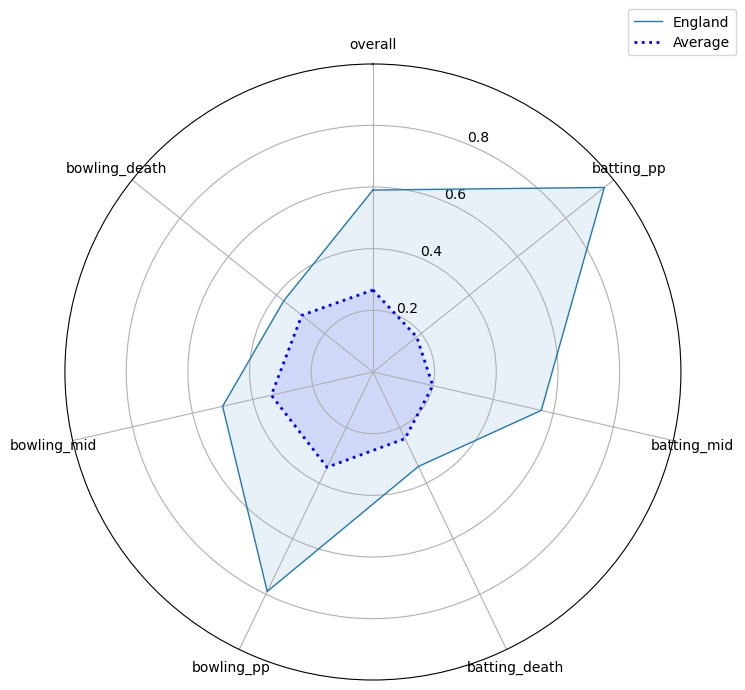

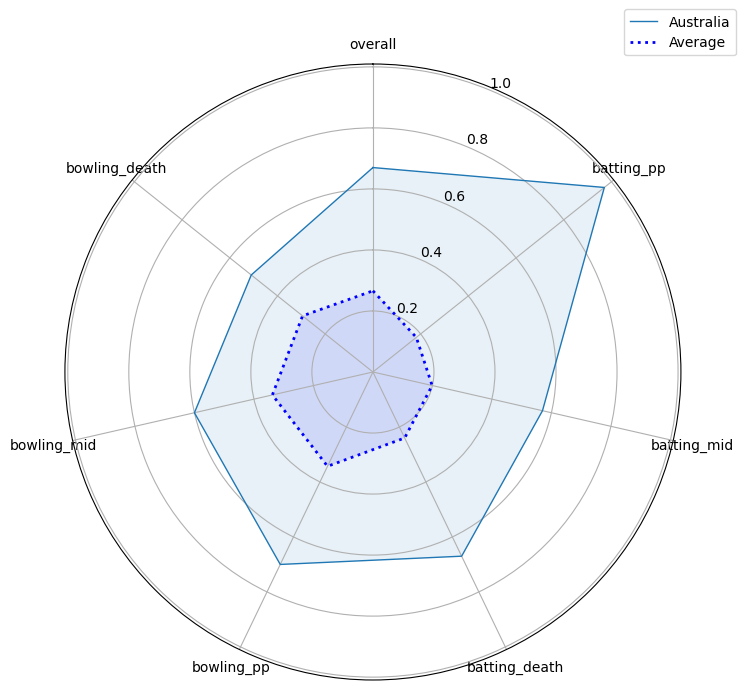

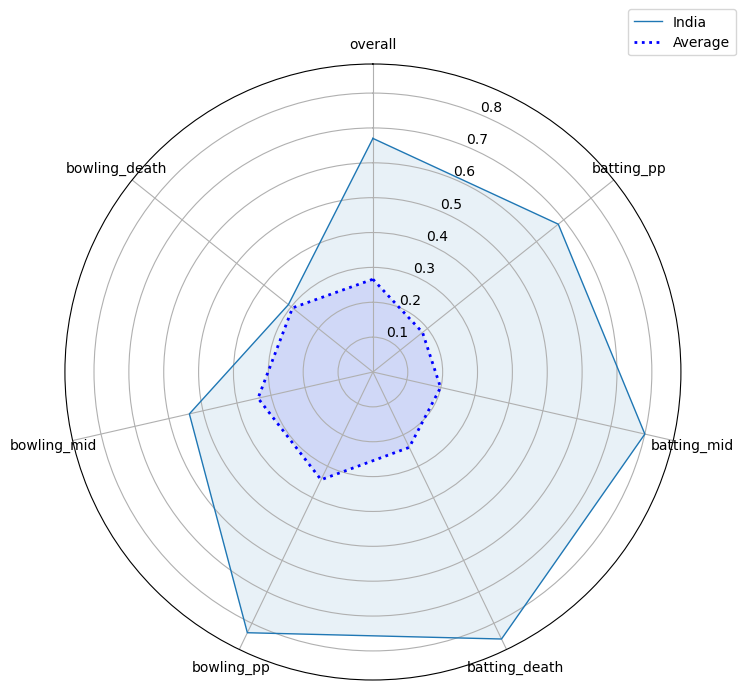

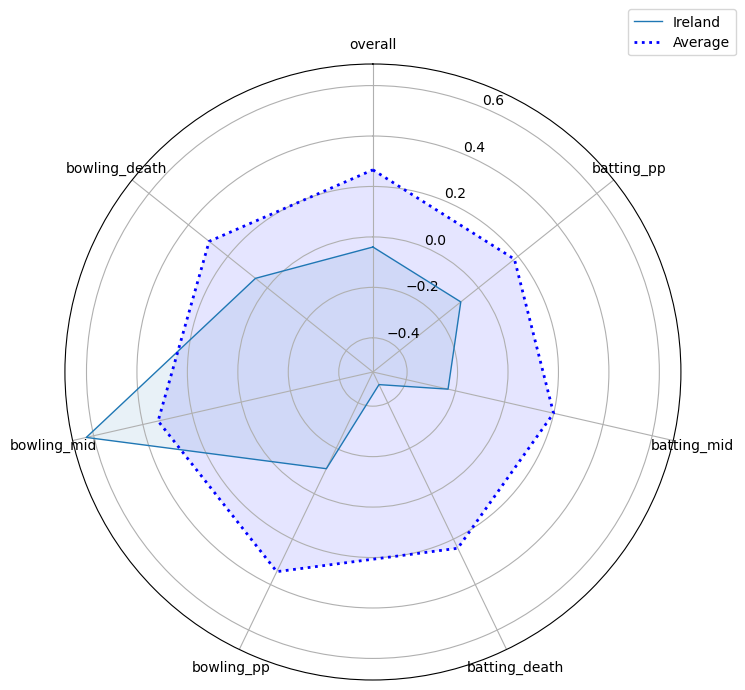

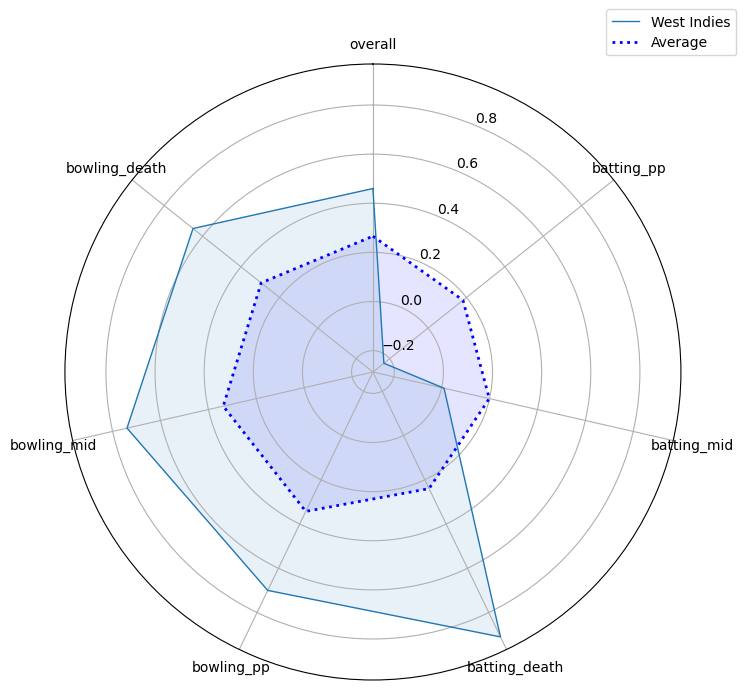

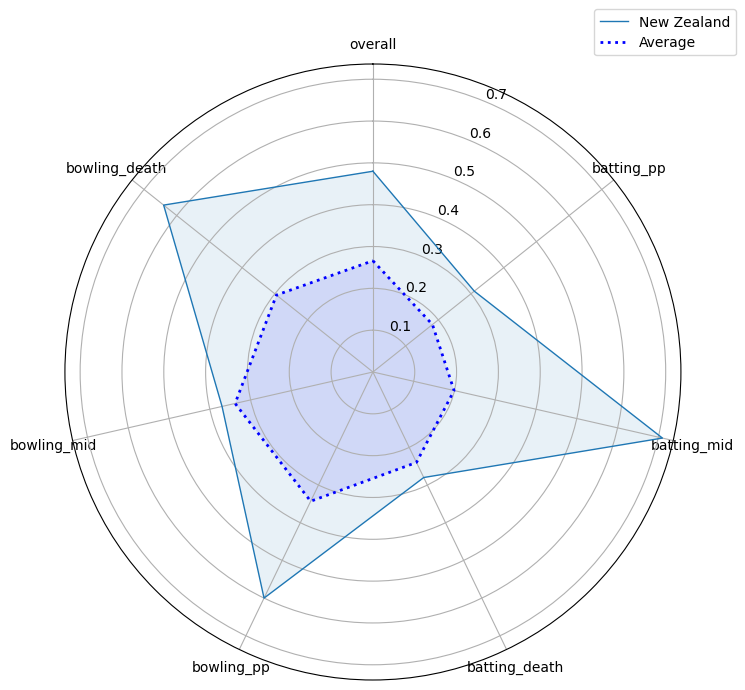

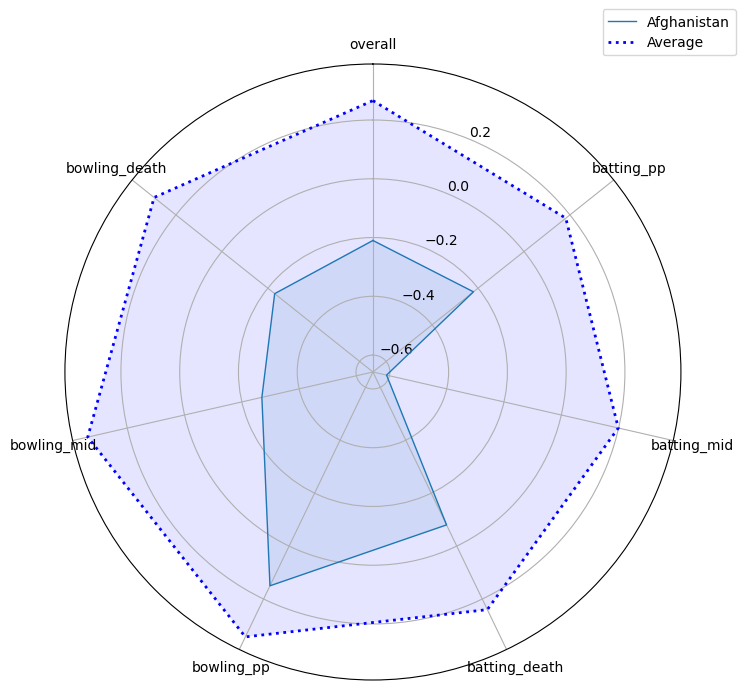

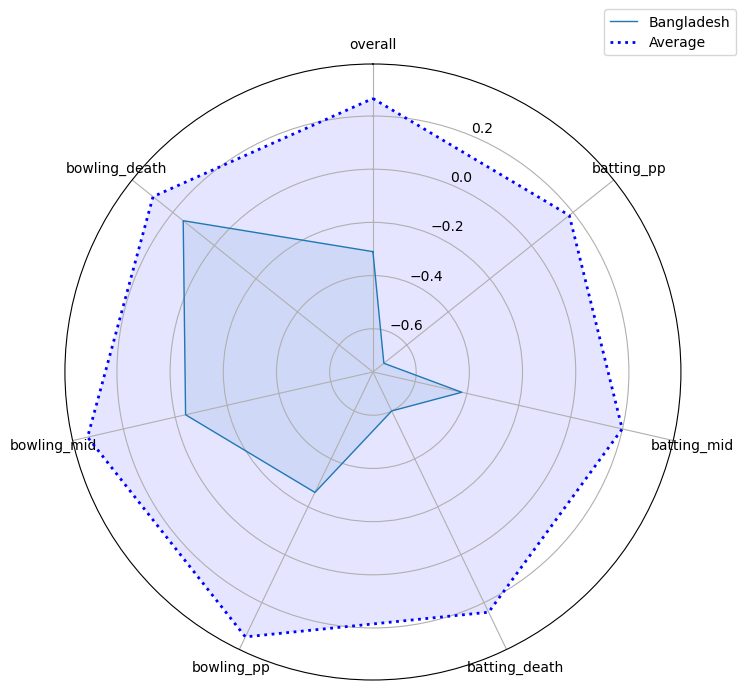

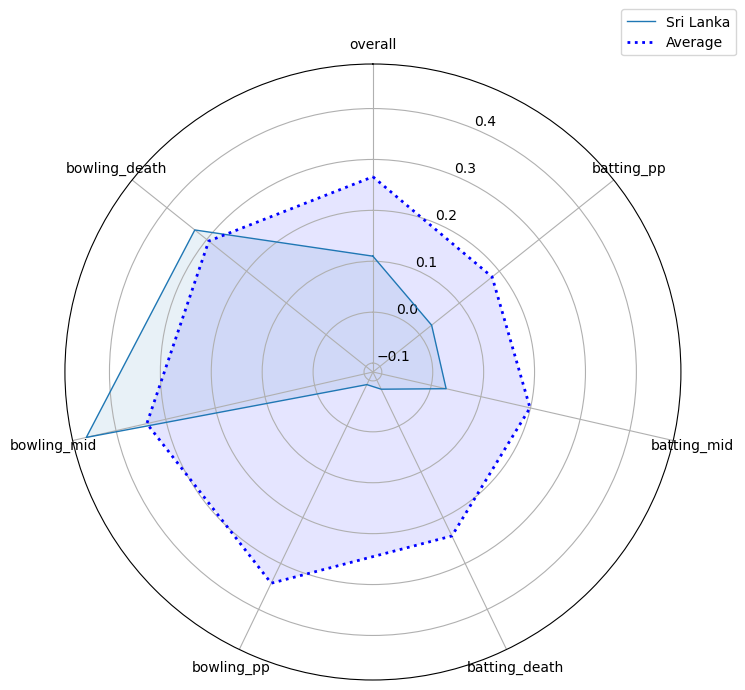

In [93]:
for country in df_phases.index:
    spider_plot_stats(df_phases,country)